## Import the needed package

In [1]:
# package to get the custom modules
import sys
# get the custom modules
sys.path.insert(0, './../../utilities')
# package for handling files
import os
# the custom modules
import utilities as util
# package for handling path
import paths
# package to handle random numbers
from random import randint

c:\Users\Bugi\miniconda3\envs\modeling\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Bugi\miniconda3\envs\modeling\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.

## Global Variable

In [2]:
# paths where dataset is stored
path_test_ori = os.path.join(paths.path_split_origin, 'test')
path_test_aug = os.path.join(paths.path_split_augment, 'test')

## Get Dataset

In [3]:
# get the image and mask files
test_ori_img, test_ori_mask = util.load_img_mask(path_test_ori)
test_aug_img, test_aug_mask = util.load_img_mask(path_test_aug)
# create the tensorflow dataset
testset_ori = util.create_dataset(test_ori_img, test_ori_mask)
testset_aug = util.create_dataset(test_aug_img, test_aug_mask)

## Experiment

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import label, regionprops
import tensorflow as tf

In [120]:
def ev_cdr(model:tf.keras.Model, img_path:str, mask_path:str, threshold:float=.5, img_size:int=128):
    """calculate the CDR value of the given image with the given model

    Args:
        model (tf.keras.Model): the model that will be used
        img_path (str): the path of the test image
        mask_path (str): the path of the mask image
        threshold (float, optional): threshold define active pixel to make binary image. Defaults to .5.
        img_size (int, optional): the size of image in rasio of 1:1. Defaults to 128.

    Returns:
        dict: the CDR value
    """
    # preprocess and get the image
    img = tf.io.read_file(img_path)                                         # read the image
    img = tf.image.decode_jpeg(img, channels=3)                             # read the jpg file to readable type
    img = tf.image.resize(img, (img_size, img_size), method='nearest')      # change the image size
    img = tf.cast(img, tf.float32) / 255.                                   # normalize the image
    img = tf.expand_dims(img, axis=0)                                       # change the shape of the image to simulate batch dataset

    # predict the image
    pred_mask = model.predict(img, verbose=0)

    # split the mask image to a binary mask image
    cup_mask = tf.where(pred_mask[..., 1] > threshold, 1, 0)
    disc_mask = tf.where(pred_mask[..., 2] > threshold, 1, 0)

    # create a bounding box for each binary image (will get the coordinate)
    cup_bbox = regionprops(label(cup_mask.numpy())[0])[0].bbox
    disc_bbox = regionprops(label(disc_mask.numpy())[0])[0].bbox

    # cup_bbox = [0,0, 0,0]
    # disc_bbox = [0,0, 0,0]

    # cup_bbox[1], cup_bbox[3], cup_bbox[0], cup_bbox[2], _,_ = util.get_bounding_box(cup_mask[0].numpy())
    # disc_bbox[1], disc_bbox[3], disc_bbox[0], disc_bbox[2], _,_ = util.get_bounding_box(disc_mask[0].numpy())

    # calculate the size of bounding box
    cup_width = cup_bbox[3] - cup_bbox[1]
    cup_height = cup_bbox[2] - cup_bbox[0]
    disc_width = disc_bbox[3] - disc_bbox[1]
    disc_height = disc_bbox[2] - disc_bbox[0]

    # crop the disc area
    disc_crop = img[0, disc_bbox[0]:disc_bbox[2], disc_bbox[1]:disc_bbox[3], :]

    # split the disc area
    h, w, c = disc_crop.shape
    mid = w // 2
    left = disc_crop[:, :mid, :]
    right = disc_crop[:, mid:, :]

    # extract green channel
    left_green = left[..., 1]
    right_green = right[..., 1]

    # count the pixels intensity
    left_intensity = tf.reduce_sum(left_green).numpy()
    right_intensity = tf.reduce_sum(right_green).numpy()

    # result of eye side
    if left_intensity > right_intensity:
        eye_side = "right"
    elif left_intensity < right_intensity:
        eye_side = "left"
    else:
        eye_side = "uncertain"

    # visualize the result
    plt.figure(figsize=(10, 10))

    # show the original mask of the given fundus image
    plt.subplot(3,2, 1)
    plt.imshow(plt.imread(mask_path), cmap="gray")                      # show image
    plt.title("Original Mask")
    plt.axis("off")

    # show the predicted mask with bounding box on it
    plt.subplot(3,2, 2)
    plt.imshow(tf.argmax(pred_mask, axis=-1)[0], cmap="gray")           # show image
    plt.gca().add_patch(plt.Rectangle((cup_bbox[1], cup_bbox[0]),       # show bounding box of cup
                                    cup_width, cup_height,
                                    edgecolor='b', facecolor='none'))
    plt.gca().add_patch(plt.Rectangle((disc_bbox[1], disc_bbox[0]),     # show bounding box of disc
                                    disc_width, disc_height,
                                    edgecolor='c', facecolor='none'))
    plt.title("Predicted Mask")
    plt.axis("off")

    # show the original image with bouding box on it
    plt.subplot(3,2, 3)
    plt.imshow(img[0])
    plt.gca().add_patch(plt.Rectangle((cup_bbox[1], cup_bbox[0]),
                                        cup_width, cup_height,
                                        edgecolor='b', facecolor='none'))
    plt.gca().add_patch(plt.Rectangle((disc_bbox[1], disc_bbox[0]),
                                        disc_width, disc_height,
                                        edgecolor='c', facecolor='none'))
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(3,2, 4)
    plt.imshow(disc_crop)
    plt.axvline(x=mid, color='g', linestyle='--', linewidth=2)
    plt.title(f"Cropped Disc Area ({eye_side} eye)")
    plt.axis("off")

    plt.subplot(3,2, 5)
    plt.imshow(left_green, cmap="gray")
    plt.title(f"Left Green Channel: {left_intensity:.2f}")
    plt.axis("off")

    plt.subplot(3,2, 6)
    plt.imshow(right_green, cmap="gray")
    plt.title(f"Right Green Channel: {right_intensity:.2f}")
    plt.axis("off")

    plt.show()

    # # calculate the CDR value
    # return {"origin img": img}

In [122]:
idx = randint(0, len(test_ori_img)-1)
test_ori_img[idx].split('\\')[-1]

'fff_0_48763_r_2.jpg'

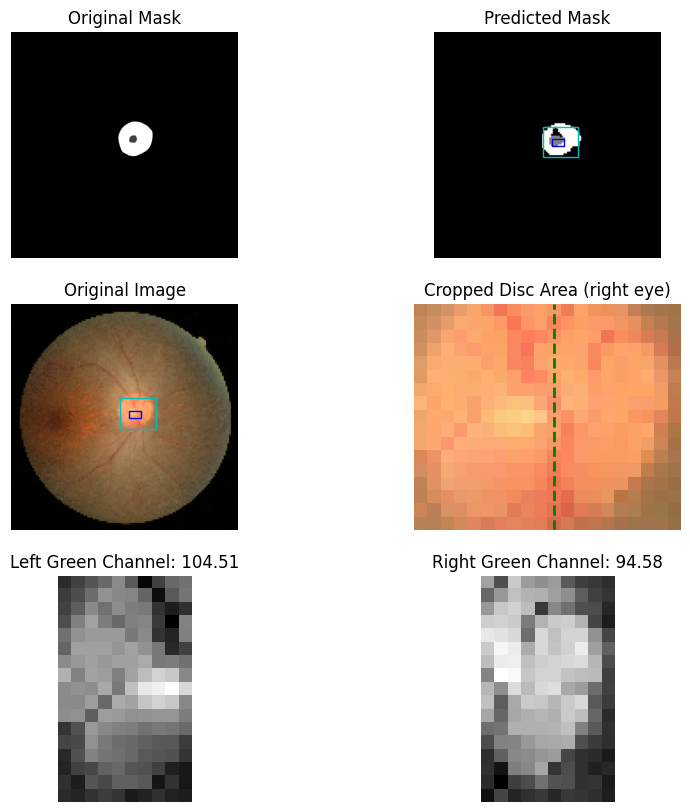

In [123]:
ev_cdr(
    model=util.custom_load_model(os.path.join(paths.path_model, f"unet_model_ori.h5")),
    img_path=test_ori_img[idx],
    mask_path=test_ori_mask[idx],
    threshold=.76
)